# **Stop Sign Detection Using YOLO and Automatic Geotag retrieval**

**Summary**: The program attached to this summary report detects stop signs in an image and extracts
geographical coordinates of the image from its metadata, if available. This code uses the YOLO8 library
for stop detection and PIL for extracting geolocation data of the image.

**Inputs and Outputs:** Input to the code is a sequence of images stored in the ‘image’ folder. The code
processes all images and summarizes the results in a csv file ‘stop_detection_result.csv’ which contains
image names, confidence Score in detecting stop signs, Latitudes, and Longitudes. Additionally, the
folder ‘stop_detection_result_images’ contains the original images with a box around all detected
objects. YOLO8 pre-trained model detects 79 different objects. The traffic-related objects detectable by
the pre-trained model include vehicles, stop signs, traffic lights, parking meters, and fire hydrants.
However, YOLO8 can be trained to detect any object.

**Code Description:**
The line-by-line description of the code is presented as follows:
The following lines import the required libraries. If a library is not already installed, use ‘pip install
library_name’ in cmd to install it.

# ***Step 1: Load needed Python libraries***

In [2]:
%%capture
# @markdown ### Run this to load the required libraries
!pip install ultralytics

from ultralytics import YOLO
import os
from PIL import Image, ExifTags
import numpy as np
from glob import glob
import csv
from google.colab import drive
import pandas as pd

# ***Step 2: Get the input Images***

Connect to virtual drive to get the input video file. Alternatively, you can upload your images to the colab directly from your computer.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#@markdown ### Choose folder address for images:
folder_path ='/content/drive/MyDrive/Stop_Detection/images' #@param {type:"string"}

#@markdown ### Set output directory:
output_path ='/content/output' #@param {type:"string"}

if not os.path.exists(output_path): os.mkdir(output_path)

folder_path=folder_path+'/*'
images = glob(folder_path)

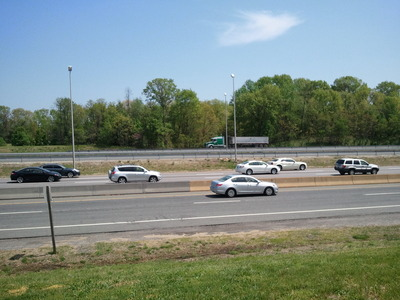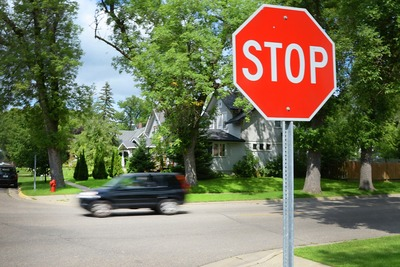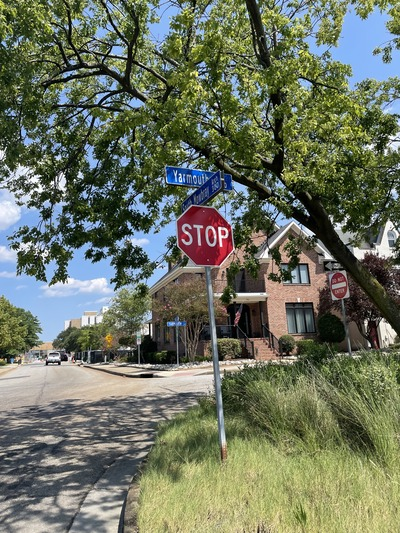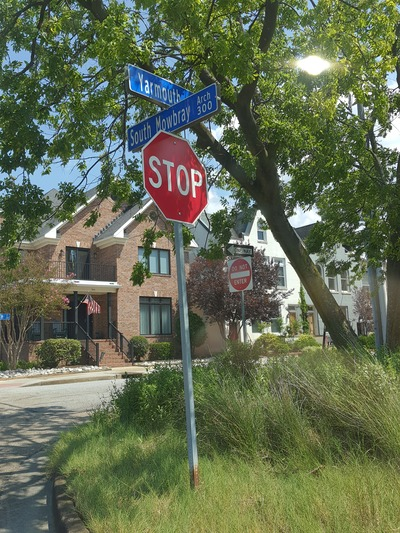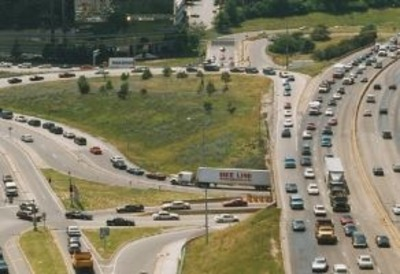

# ***Step 3: Run the model***

Loading YOLO8 pre-trained model


In [ ]:
model = YOLO('yolov8m.pt')

Performing detection on all images


In [ ]:
results = model(images)



0: 640x640 7 cars, 1 train, 1 truck, 1: 640x640 2 cars, 1 fire hydrant, 1 stop sign, 2: 640x640 1 stop sign, 3: 640x640 1 car, 1 stop sign, 4: 640x640 25 cars, 1 truck, 5: 640x640 1 car, 3 stop signs, 8569.3ms
Speed: 5.3ms preprocess, 1428.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Creating an empty list for the output file and creating header line for it


In [ ]:
result_list=[]
result_list.append(['File Name', 'Confidence Score', 'Latitude', 'Longitude'])

A For loop to process each result:
The first line in the For loop extracts the ID of the detected objects. The pre-trained model detects 79 different
objects, each labeled from 1 to 79. The ID for the stop sign is 11.
The second line extracts the confidence score of the detected objects.
If no stop sign is detected the confidence score is set to 0.
The lines after the If statement extract latitude and longitude from the image's metadata. If the location is not recorded,
latitude and longitude are set to 999.
The next lines add the file name, conf, lat, and lon of the processed image to the output list.
The final lines in For loop save the output image in the folder 'stop_detection_result_images'



In [ ]:
for i,r in enumerate(results): # a for loop to process each result #
    class_list = r.boxes.cls.numpy() # this line extracts the ID of the detected objects. The pretrained model detects 90 different objects each labled from 1 to 90. The ID for stop sign object is 11.#
    conf_list = r.boxes.conf.numpy() # this line extracts the confidence score of the detected objects #

    #### if no stop sign is detected the confidence score is set to 0 ####
    indices= np.where(class_list==11)[0]
    if indices.shape == (0,):
        conf = 0
    else:
        conf = np.max(conf_list[indices])

    ### these lines extract lat and lon from the image's meta data. If the location is not recorded, lat and lon are set to 999 ###
    try:
        img=Image.open(images[i])
        img._getexif()
        exif = {ExifTags.TAGS[k]: v for k,v in img._getexif().items()}
        lat =  exif['GPSInfo'][2][0]+exif['GPSInfo'][2][1]/60.+exif['GPSInfo'][2][2]/3600.
        lon =  exif['GPSInfo'][4][0]+exif['GPSInfo'][4][1]/60.+exif['GPSInfo'][4][2]/3600.
        lon = -lon
    except:
        lat=999
        lon=999

    # these lines add file name, conf, lat, lon of the proccessed image to the output list
    file_name = images[i].split('/')[6]
    result_list.append([file_name,f'{conf:.3f}',f'{lat:.5f}',f'{lon:.5f}'])
     # these lines save the output image in folder 'stop_detection_result_images'
    im_array = r.plot()
    im = Image.fromarray(im_array[..., ::-1])
    im.save(os.path.join(output_path,'result_{}'.format(file_name)))

Finally, we can write the output list to a csv file.

In [ ]:
csv_file_path = os.path.join(output_path,'stop_detection_result.csv')
df = pd.DataFrame(result_list)
df.to_csv(csv_file_path, mode='w', index=False)
df

,0,1,2,3
0,File Name,Confidence Score,Latitude,Longitude
1,Vehicles on Hyw.jpg,0.000,0.00000,-0.00000
2,stopsign.jpeg,0.977,999.00000,999.00000
3,mystopsign.jpg,0.962,36.85460,-76.29450
4,mystopsign2.jpg,0.946,36.85552,-76.29386
5,hfl_62801b.jpg,0.000,999.00000,999.00000
6,stop.jpg,0.970,999.00000,999.00000
